# Modelling the effects of distToHalfQuarter, anchoring and rounding in the task performance of estimation in part-to-whole charts


In [2]:
library(ggplot2)
library(dplyr)
library(ggdist)
library(lme4)
library(ggeffects)
library(patchwork)
library(lmerTest)
library(brms)
library(blme)

In [41]:
# Load data
lineData <- read.csv("data/alignmentDistsStudy7Line.csv", header=T)
pieData <- read.csv("data/alignmentDistsStudy7Pie.csv", header=T)
lineData$chartType <- "line"
pieData$chartType <- "pie"

lineData$alignment <- factor(lineData$alignment, levels = c("aligned", "non-aligned"))

lineData <- lineData %>%
  mutate(alignmentCategory = case_when(
    distToHorizontalVertical == 0 ~ "aligned",
    distToHorizontalVertical >= 1 & distToHorizontalVertical <= 4 ~ "near-aligned",
    distToHorizontalVertical >= 5 ~ "far"
  ))

pieData <- pieData %>%
  mutate(alignmentCategory = case_when(
    distToHorizontalVertical == 0 ~ "aligned",
    distToHorizontalVertical >= 1 & distToHorizontalVertical <= 4 ~ "near-aligned",
    distToHorizontalVertical >= 5 ~ "far"
  ))

lineData <- lineData %>%
  mutate(
    anchor = ifelse(distToHalfQuarter == 0, "anchor", "non-anchor"),
    anchorCategory = case_when(
      distToHalfQuarter == 0 ~ "anchor",
      distToHalfQuarter >= 1 & distToHalfQuarter <= 4 ~ "near-anchor",
      distToHalfQuarter >= 5 ~ "far"
    ),
    anchor = factor(anchor, levels = c("anchor", "non-anchor")),
    anchorCategory = factor(anchorCategory, levels = c("anchor", "near-anchor", "far"))
  )

pieData <- pieData %>%
  mutate(
    anchor = ifelse(distToHalfQuarter == 0, "anchor", "non-anchor"),
    anchorCategory = case_when(
      distToHalfQuarter == 0 ~ "anchor",
      distToHalfQuarter >= 1 & distToHalfQuarter <= 4 ~ "near-anchor",
      distToHalfQuarter >= 5 ~ "far"
    ),
    anchor = factor(anchor, levels = c("anchor", "non-anchor")),
    anchorCategory = factor(anchorCategory, levels = c("anchor", "near-anchor", "far"))
  )

lineData <- lineData %>%
  mutate(
    anchorType = case_when(
      distToHalfQuarter == 0 & correctResponse == 25 ~ "25",
      distToHalfQuarter == 0 & correctResponse == 50 ~ "50",
      distToHalfQuarter == 0 & correctResponse == 75 ~ "75",
      TRUE ~ "non-anchor"
    ),
    anchorType = factor(anchorType, levels = c("25", "50", "75", "non-anchor"))
  )

pieData <- pieData %>%
  mutate(
    anchorType = case_when(
      distToHalfQuarter == 0 & correctResponse == 25 ~ "25",
      distToHalfQuarter == 0 & correctResponse == 50 ~ "50",
      distToHalfQuarter == 0 & correctResponse == 75 ~ "75",
      TRUE ~ "non-anchor"
    ),
    anchorType = factor(anchorType, levels = c("25", "50", "75", "non-anchor"))
  )

lineData$alignmentCategory <- factor(lineData$alignmentCategory, levels = c("aligned", "near-aligned", "far"))
pieData$alignmentCategory <- factor(pieData$alignmentCategory, levels = c("aligned", "near-aligned", "far"))

lineData$distToNearest5 <- abs(lineData$correctResponse - round(lineData$correctResponse / 5) * 5)
lineData$D5_factor <- factor(lineData$distToNearest5)
lineData$distToNearest10 <- abs(lineData$correctResponse - round(lineData$correctResponse / 10) * 10)

pieData$distToNearest5 <- abs(pieData$correctResponse - round(pieData$correctResponse / 5) * 5)
pieData$D5_factor <- factor(pieData$distToNearest5)
pieData$distToNearest10 <- abs(pieData$correctResponse - round(pieData$correctResponse / 10) * 10)

pieData$userID <- pieData$userID + max(lineData$userID) + 1  # e.g., if lineData has IDs 0–39, pieData gets 40–79
data <- rbind(lineData, pieData)

In [45]:
lineModel <- lmer(
  absDiff ~ alignment + anchor + distToNearest5 + alignment:anchor + (1 + alignment + anchor + distToNearest5 | userID),
  data = lineData
)
summary(lineModel)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 1 negative eigenvalue: -3.0e+01”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ alignment + anchor + distToNearest5 + alignment:anchor +  
    (1 + alignment + anchor + distToNearest5 | userID)
   Data: lineData

REML criterion at convergence: 15698.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6019 -0.4663 -0.1371  0.2388 16.7259 

Random effects:
 Groups   Name                 Variance Std.Dev. Corr             
 userID   (Intercept)          0.3651   0.6042                    
          alignmentnon-aligned 0.4190   0.6473   -1.00            
          anchornon-anchor     0.6459   0.8037   -0.78  0.78      
          distToNearest5       0.1976   0.4445   -0.27  0.27 -0.39
 Residual                      7.6897   2.7730                    
Number of obs: 3200, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error         df t value
(Intercept)                             -0.01252    0.31237  285.9

In [30]:
m_anchoring <- lmer(
  absDiff ~ alignment * anchor + (1 | userID),
  data = subset(lineData, distToNearest5 == 0)
)
summary(m_anchoring)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ alignment * anchor + (1 | userID)
   Data: subset(lineData, distToNearest5 == 0)

REML criterion at convergence: 3413.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8536 -0.3785 -0.0917  0.1951 12.9134 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept)  0.00    0.000   
 Residual             12.16    3.487   
Number of obs: 640, groups:  userID, 40

Fixed effects:
                                       Estimate Std. Error        df t value
(Intercept)                           2.809e-16  3.738e-01 6.360e+02   0.000
alignmentnon-aligned                  1.260e+00  5.534e-01 6.360e+02   2.277
anchornon-anchor                      1.320e+00  4.300e-01 6.360e+02   3.069
alignmentnon-aligned:anchornon-anchor 3.963e-01  6.396e-01 6.360e+02   0.620
                                      Pr(>|t|)   
(Intercept)                            1.0000

In [24]:
levels(lineData$D5_factor)

[1] "0" "1" "2"

In [25]:
m_full <- lmer(
  absDiff ~ alignment * anchor * D5_factor + (1 | userID),
  data = lineData
)
summary(m_full)

fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ alignment * anchor * D5_factor + (1 | userID)
   Data: lineData

REML criterion at convergence: 15749.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2781 -0.4686 -0.1705  0.1929 16.7037 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.1687   0.4107  
 Residual             7.9236   2.8149  
Number of obs: 3200, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error         df t value
(Intercept)                            5.104e-03  3.088e-01  2.491e+03   0.017
alignmentnon-aligned                   1.249e+00  4.470e-01  3.157e+03   2.794
anchornon-anchor                       1.322e+00  3.473e-01  3.155e+03   3.807
D5_factor1                            -2.407e-02  2.038e-01  3.154e+03  -0.118
D5_factor2                             9.807e-02  2.030e-01  3.154e+03   0.483
alignmentnon-aligned:

In [170]:
model_interact <- lmer(
  absDiff ~ alignment * distToHalfQuarter + (1 | userID),
  data = lineData
)
summary(model_interact)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ alignment * distToHalfQuarter + (1 | userID)
   Data: lineData

REML criterion at convergence: 15717.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4404 -0.4500 -0.1556  0.1967 16.9136 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.1756   0.4191  
 Residual             7.8191   2.7963  
Number of obs: 3200, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error        df t value
(Intercept)                            4.519e-01  1.536e-01 4.326e+02   2.942
alignmentnon-aligned                   1.281e+00  1.960e-01 3.157e+03   6.536
distToHalfQuarter                      1.286e-01  1.862e-02 3.157e+03   6.906
alignmentnon-aligned:distToHalfQuarter 1.059e-02  2.633e-02 3.157e+03   0.402
                                       Pr(>|t|)    
(Intercept)                             0.00343 ** 
al

In [ ]:
model <- lmer(
    absDiff ~ chartType * (a + distToHorizontalVertical + distToNearest5) + (1 + distToHalfQuarter + distToHorizontalVertical + distToNearest5 | userID),
    data = data
)
summary(model)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 1 negative eigenvalue: -5.4e+02”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical +  
    distToNearest5) + (1 + distToHalfQuarter + distToHorizontalVertical +  
    distToNearest5 | userID)
   Data: data

REML criterion at convergence: 32345.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8097 -0.5134 -0.1904  0.2435 22.6788 

Random effects:
 Groups   Name                     Variance Std.Dev. Corr             
 userID   (Intercept)              0.578361 0.76050                   
          distToHalfQuarter        0.007700 0.08775  -0.57            
          distToHorizontalVertical 0.007865 0.08868  -0.71  0.98      
          distToNearest5           0.084194 0.29016   0.04 -0.63 -0.55
 Residual                          8.932529 2.98873                   
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error         df t

In [135]:
model <- lmer(
    absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest5) + (1 | userID),
    data = data
)
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical +  
    distToNearest5) + (1 | userID)
   Data: data

REML criterion at convergence: 32548.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3298 -0.5171 -0.2211  0.2247 22.9445 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.2632   0.513   
 Residual             9.3208   3.053   
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error         df t value
(Intercept)                              0.83504    0.16682  450.58582   5.006
chartTypepie                             0.89427    0.20608 6353.00161   4.340
distToHalfQuarter                        0.12949    0.01447 6353.02590   8.950
distToHorizontalVertical                 0.01650    0.01597 6364.09076   1.034
distToNearest5                           0.18244    0

In [138]:
model <- lmer(
    absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest10) + (1 | userID),
    data = data
)
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical +  
    distToNearest10) + (1 | userID)
   Data: data

REML criterion at convergence: 32562.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2845 -0.5174 -0.2149  0.2310 22.9814 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.2631   0.5129  
 Residual             9.3371   3.0557  
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                                        Estimate Std. Error         df t value
(Intercept)                              0.91273    0.17028  486.92852   5.360
chartTypepie                             0.88881    0.21167 6353.00160   4.199
distToHalfQuarter                        0.13214    0.01442 6353.02460   9.161
distToHorizontalVertical                 0.01596    0.01598 6364.10487   0.999
distToNearest10                          0.05055    

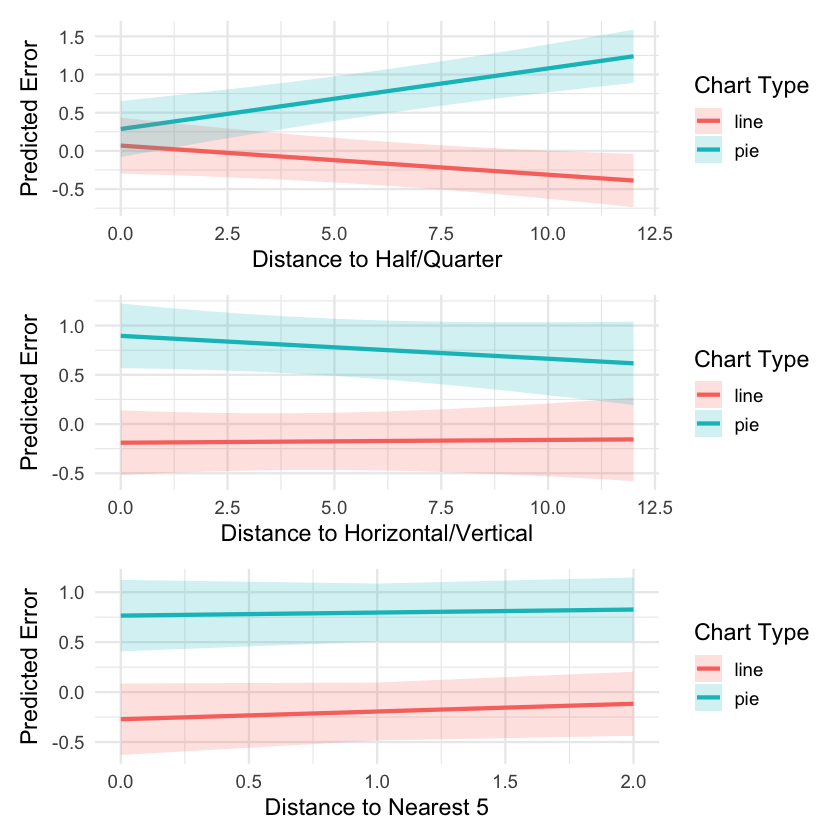

In [ ]:
pred_halfquarter <- ggpredict(model_interact, terms = c("distToHalfQuarter", "chartType"))
pred_horizvert   <- ggpredict(model_interact, terms = c("distToHorizontalVertical", "chartType"))
pred_nearest5    <- ggpredict(model_interact, terms = c("distToNearest5", "chartType"))

# Define a function for plotting
plot_pred <- function(pred_df, xlab_title) {
  ggplot(pred_df, aes(x = x, y = predicted, color = group)) +
    geom_line(size = 1.2) +
    geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = group), alpha = 0.2, color = NA) +
    labs(x = xlab_title, y = "Predicted Error", color = "Chart Type", fill = "Chart Type") +
    theme_minimal(base_size = 14)
}

# Make the three plots
plot_halfquarter <- plot_pred(pred_halfquarter, "Distance to Half/Quarter")
plot_horizvert   <- plot_pred(pred_horizvert, "Distance to Horizontal/Vertical")
plot_nearest5    <- plot_pred(pred_nearest5, "Distance to Nearest 5")

plot_halfquarter / plot_horizvert / plot_nearest5

In [51]:
model_interact <- lmer(
  absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest5) + (1 | userID),
  data = data
)
model_no_interact <- lmer(
  absDiff ~ distToHalfQuarter + distToHorizontalVertical + distToNearest5 + chartType + (1 | userID),
  data = data
)

anova(model_no_interact, model_interact)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_no_interact,7,32524.83,32572.18,-16255.42,32510.83,NA,NA,NA
model_interact,10,32529.13,32596.77,-16254.56,32509.13,1.707794,3,0.6352023


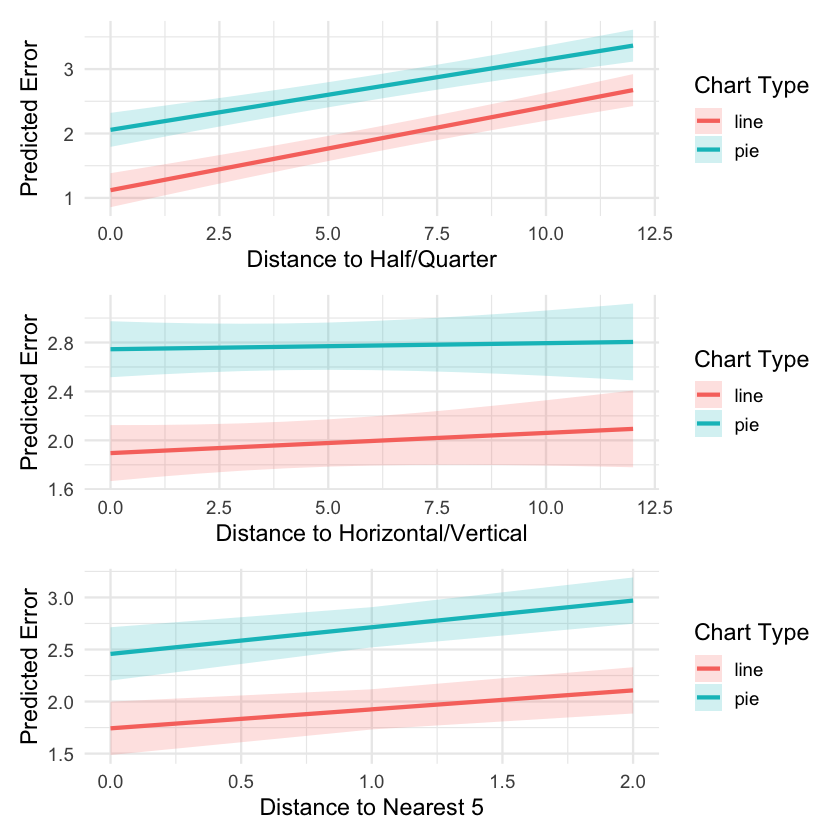

In [53]:
pred_halfquarter <- ggpredict(model_interact, terms = c("distToHalfQuarter", "chartType"))
pred_horizvert   <- ggpredict(model_interact, terms = c("distToHorizontalVertical", "chartType"))
pred_nearest5    <- ggpredict(model_interact, terms = c("distToNearest5", "chartType"))

# Define a function for plotting
plot_pred <- function(pred_df, xlab_title) {
  ggplot(pred_df, aes(x = x, y = predicted, color = group)) +
    geom_line(size = 1.2) +
    geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = group), alpha = 0.2, color = NA) +
    labs(x = xlab_title, y = "Predicted Error", color = "Chart Type", fill = "Chart Type") +
    theme_minimal(base_size = 14)
}

# Make the three plots
plot_halfquarter <- plot_pred(pred_halfquarter, "Distance to Half/Quarter")
plot_horizvert   <- plot_pred(pred_horizvert, "Distance to Horizontal/Vertical")
plot_nearest5    <- plot_pred(pred_nearest5, "Distance to Nearest 5")

plot_halfquarter / plot_horizvert / plot_nearest5

In [43]:
model_mixed <- lmer(
  absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * alignment) +
    (1 + distToNearest5 + distToHalfQuarter + alignment | userID),
  data = data,
  REML = FALSE  # for comparability and inference on fixed effects
)

summary(model_mixed)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0650295 (tol = 0.002, component 1)”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * alignment) +  
    (1 + distToNearest5 + distToHalfQuarter + alignment | userID)
   Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  32325.0   32467.0  -16141.5   32283.0      6379 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8540 -0.5209 -0.1875  0.2533 22.6421 

Random effects:
 Groups   Name                 Variance Std.Dev. Corr             
 userID   (Intercept)          0.721947 0.84967                   
          distToNearest5       0.078918 0.28092  -0.08            
          distToHalfQuarter    0.006653 0.08157  -0.59 -0.53      
          alignmentnon-aligned 0.267994 0.51768  -0.83 -0.26  0.93
 Residual                      8.880806 2.98007                   
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                                                    

In [149]:
model <- lmer(
  absDiff ~ chartType * (distToHalfQuarter * distToHorizontalVertical) +
    (1 | userID),
  data = data
)
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
absDiff ~ chartType * (distToHalfQuarter * distToHorizontalVertical) +  
    (1 | userID)
   Data: data

REML criterion at convergence: 32578.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2707 -0.5227 -0.2103  0.2310 22.9752 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.2631   0.5129  
 Residual             9.3479   3.0574  
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                                                          Estimate Std. Error
(Intercept)                                              1.002e+00  1.736e-01
chartTypepie                                             1.048e+00  2.170e-01
distToHalfQuarter                                        1.383e-01  2.080e-02
distToHorizontalVertical                                 2.406e-02  2.928e-02
distToHalfQuarter:distToHorizontalVertical              -1.314e-03  3.907e

In [152]:
model_pie <- lmer(
  absDiff ~ (distToHalfQuarter * distToHorizontalVertical) + (1 | userID),
  data = pieData
)
summary(model_pie)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ (distToHalfQuarter * distToHorizontalVertical) + (1 |  
    userID)
   Data: pieData

REML criterion at convergence: 16488.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5323 -0.5144 -0.1804  0.3260 22.1607 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 1.008    1.004   
 Residual             9.784    3.128   
Number of obs: 3200, groups:  userID, 40

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                 2.077e+00  2.234e-01  1.207e+02
distToHalfQuarter                           1.041e-01  2.130e-02  3.160e+03
distToHorizontalVertical                   -1.495e-02  3.001e-02  3.162e+03
distToHalfQuarter:distToHorizontalVertical  2.683e-03  4.005e-03  3.163e+03
                                           t value Pr(>|t|)    
(Intercept)                   

In [151]:
model_line <- lmer(
  absDiff ~ (distToHalfQuarter * distToHorizontalVertical) + (1 | userID),
  data = lineData
)
summary(model_line)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absDiff ~ (distToHalfQuarter * distToHorizontalVertical) + (1 |  
    userID)
   Data: lineData

REML criterion at convergence: 15904.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1434 -0.4594 -0.2049  0.1661 16.6621 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 0.1703   0.4127  
 Residual             8.2760   2.8768  
Number of obs: 3200, groups:  userID, 40

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                 9.794e-01  1.586e-01  4.799e+02
distToHalfQuarter                           1.408e-01  1.958e-02  3.167e+03
distToHorizontalVertical                    2.997e-02  2.757e-02  3.173e+03
distToHalfQuarter:distToHorizontalVertical -1.977e-03  3.680e-03  3.175e+03
                                           t value Pr(>|t|)    
(Intercept)                  

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.



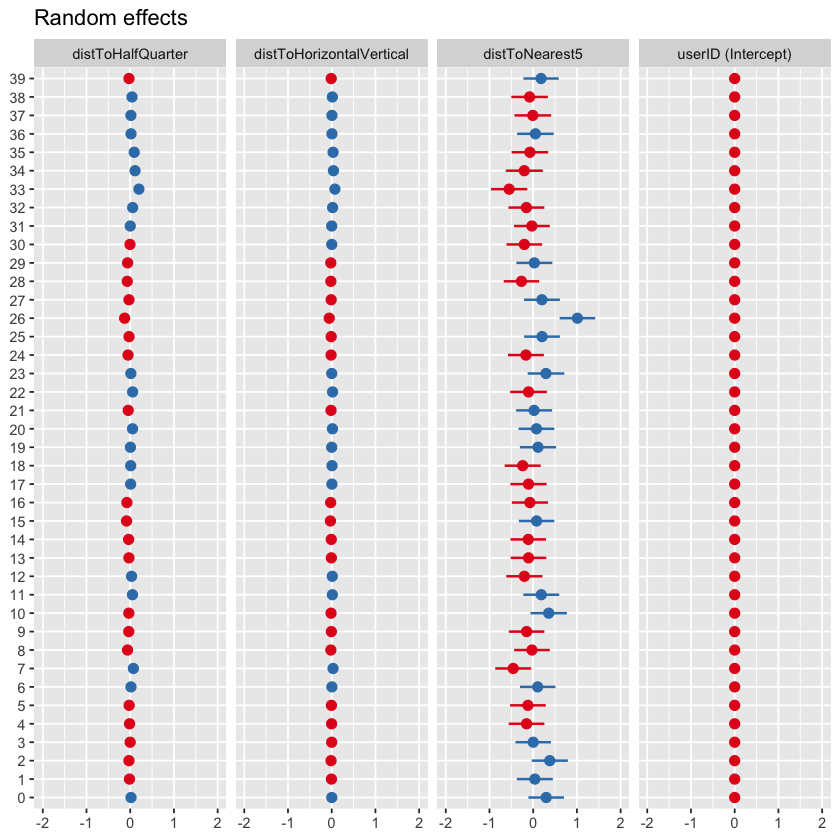

In [119]:
library(sjPlot)
plot_model(model_mixed, type = "re", sort.est = TRUE)


In [ ]:
model_mixed <- lmer(
  absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical | userID),
  data = data,
  REML = FALSE
)

summary(model_mixed)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 2 negative eigenvalues: -2.3e+00 -2.0e+03”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +  
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical |  
        userID)
   Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  32537.2   32679.3  -16247.6   32495.2      6379 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5619 -0.5142 -0.2436  0.2267 22.6164 

Random effects:
 Groups   Name                     Variance  Std.Dev. Corr             
 userID   (Intercept)              0.0000000 0.00000                   
          distToNearest5           0.1089519 0.33008    NaN            
          distToHalfQuarter        0.0046196 0.06797    NaN -0.56      
          distToHorizontalVertical 0.0006528 0.02555    NaN -0.69  0.99
 Residual                          9.2406342 3.03984                   
Number of obs: 6400, groups:  userID, 40

F